# Predicting Taxa with Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

from micropyome.taxa import regression

## Obtain Data

In [2]:
DATASET_PATH = "data/averill_processed/bacteria/"

In [3]:
X = {}
Y = {}
for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/15_variables.csv")
    if level == 'fg':
        y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")
    else:
        y = pd.read_csv(f"{DATASET_PATH}{level}/y_11groupTaxo.csv")

    x = x.drop(x.columns[0], axis=1)
    # x = StandardScaler().fit_transform(x)
    y = y.drop(y.columns[0], axis=1)

    X[level] = x
    Y[level] = y

In [4]:
X["fg"].head()

,latitude,longitude,depth_max,forest,map,map_sd,mat,mat_sd,map_CV,mat_CV,mdr,aridity,NPP,relEM,pH
0,53.444053,-2.214306,10.0,0,0.831,0.048290,9.633333,1.257395,18.28125,450.486266,7.25,1.381,0.675,0.898121,7.65
1,53.444053,-2.214306,10.0,0,0.831,0.046998,9.633333,1.217851,18.28125,450.486266,7.25,1.381,0.675,0.898121,7.67
2,53.444053,-2.214306,10.0,0,0.831,0.048770,9.633333,1.222167,18.28125,450.486266,7.25,1.381,0.675,0.898121,7.45
3,53.444053,-2.214306,10.0,0,0.831,0.048297,9.633333,1.263030,18.28125,450.486266,7.25,1.381,0.675,0.898121,7.56
4,53.444053,-2.214306,10.0,0,0.831,0.047610,9.633333,1.265757,18.28125,450.486266,7.25,1.381,0.675,0.898121,7.64


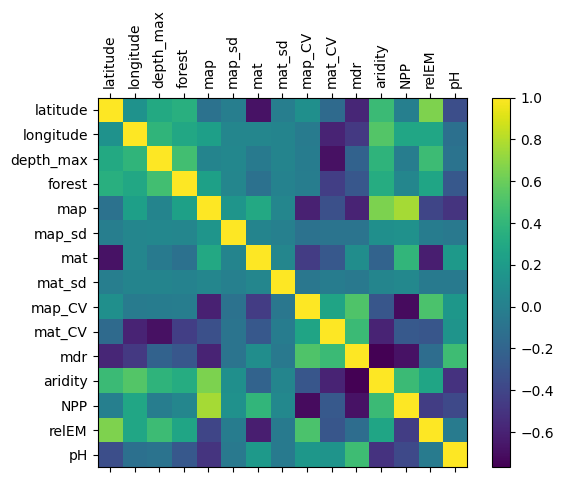

In [5]:
ex = X["fg"].copy()
from micropyome.datasets import normalize
normalize(ex)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(ex.corr())
fig.colorbar(cax)
labels = ex.columns.values
ax.set_yticks(list(range(len(labels))), labels)
ax.set_xticks(list(range(len(labels))), labels, rotation=90)
plt.show()

In [6]:
Y["fg"].head()

,other,assim_nitrate_reduction,assim_nitrite_reduction,cellulolytic,chitinolytic,copiotroph,denitrification,dissim_nitrate_reduction,dissim_nitrite_reduction,lignolytic,methanotroph,n_fixation,nitrification,oligotroph
0,0.893046,0.000957,0.002588,0.002595,0.002333,0.037817,0.003547,0.003358,0.005295,0.002366,0.000083,0.006273,0.000286,0.039454
1,0.889777,0.000788,0.004186,0.001942,0.002881,0.035736,0.003214,0.004851,0.004819,0.001714,0.000155,0.006312,0.000527,0.043100
2,0.848038,0.002428,0.006368,0.006620,0.003244,0.053938,0.008511,0.013298,0.005656,0.000937,0.000637,0.013354,0.000244,0.036729
3,0.866138,0.003326,0.004454,0.002900,0.003436,0.044006,0.005105,0.008007,0.008106,0.001687,0.000110,0.013447,0.000876,0.038404
4,0.885077,0.001408,0.000693,0.003014,0.001311,0.021446,0.004757,0.004836,0.004989,0.000560,0.000360,0.008940,0.000809,0.061803


## Create and Train Models

In [7]:
models = {
    "k-NN": KNeighborsRegressor(20),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor()),
    "Kernel Ridge": KernelRidge()
}

In [8]:
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, "other", 0.01, 5)

2024-05-24T07:44:19.380073 > INFO Evaluating 6 models with 5 splits.
2024-05-24T07:44:19.380073 > INFO Level: fg
2024-05-24T07:44:19.380073 > INFO K-fold split: 0
2024-05-24T07:44:19.391081 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:44:19.407218 >     Evaluated the model `k-NN`.
2024-05-24T07:44:19.595970 >     Evaluated the model `Linear Regression`.
2024-05-24T07:44:19.611686 >     Evaluated the model `Decision Tree`.
2024-05-24T07:44:20.552450 >     Evaluated the model `Random Forest`.
2024-05-24T07:44:23.663600 >     Evaluated the model `Gradient Boosting`.
2024-05-24T07:44:23.885761 >     Evaluated the model `Kernel Ridge`.
2024-05-24T07:44:23.887524 > INFO K-fold split: 1
2024-05-24T07:44:23.891068 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:44:23.906596 >     Evaluated the model `k-NN`.
2024-05-24T07:44:23.954768 >     Evaluated the model `Linear Regression`.
2024-05-24T07:44:23.980297 >     Evaluated the model `Decision Tree`.
2024-05-24T07:44:24.

In [9]:
averill_results = pd.read_csv(f"{DATASET_PATH}/r2_published_results.csv")
published_results = averill_results.iloc[0].to_list()[1:]

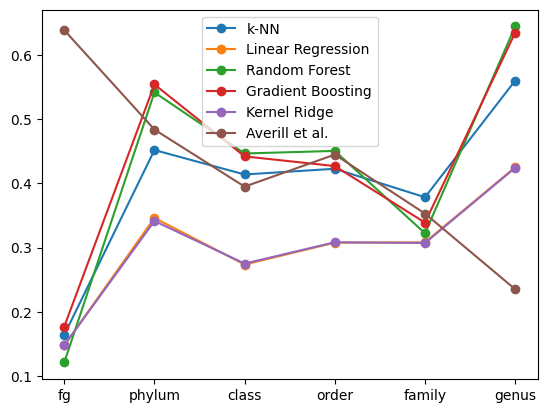

In [10]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    if model == "Decision Tree":
        continue
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.plot(x, published_results, "-o", label="Averill et al.")
plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

## Regression with Fungi

In [11]:
from micropyome.datasets import normalize, normalize_categories
from micropyome.taxa import regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

DATASET_PATH = "data/averill_processed/fungi/"
X = {}
Y = {}

for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/13_variables.csv")
    y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv")

    x = x.drop(x.columns[0], axis=1)
    x = normalize(x)
    y = y.drop(y.columns[0], axis=1)
    y = normalize_categories(y)

    X[level] = x
    Y[level] = y

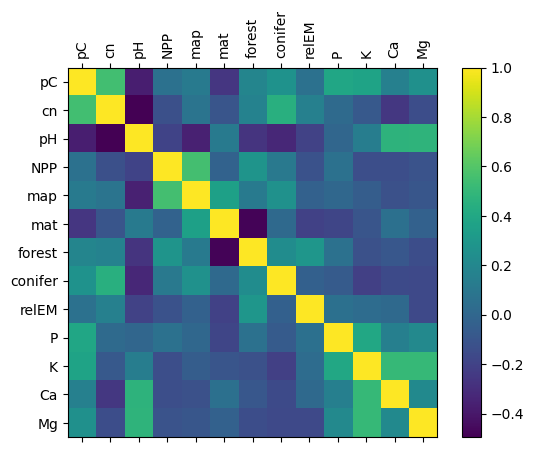

In [12]:
ex = X["fg"].copy()
from micropyome.datasets import normalize
normalize(ex)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(ex.corr())
fig.colorbar(cax)
labels = ex.columns.values
ax.set_yticks(list(range(len(labels))), labels)
ax.set_xticks(list(range(len(labels))), labels, rotation=90)
plt.show()

In [13]:
models = {
    "k-NN": KNeighborsRegressor(20),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor()),
    "Kernel Ridge": KernelRidge()
}

In [14]:
results = regression.train_evaluate_models_multiple_taxa(models, X, Y, "other", 0.01, 5)

2024-05-24T07:46:11.642086 > INFO Evaluating 6 models with 5 splits.
2024-05-24T07:46:11.642086 > INFO Level: fg
2024-05-24T07:46:11.650260 > INFO K-fold split: 0
2024-05-24T07:46:11.654280 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:46:11.668193 >     Evaluated the model `k-NN`.
2024-05-24T07:46:11.684392 >     Evaluated the model `Linear Regression`.
2024-05-24T07:46:11.715675 >     Evaluated the model `Decision Tree`.
2024-05-24T07:46:11.839757 >     Evaluated the model `Random Forest`.
2024-05-24T07:46:12.142550 >     Evaluated the model `Gradient Boosting`.
2024-05-24T07:46:12.158392 >     Evaluated the model `Kernel Ridge`.
2024-05-24T07:46:12.158392 > INFO K-fold split: 1
2024-05-24T07:46:12.158392 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:46:12.174143 >     Evaluated the model `k-NN`.
2024-05-24T07:46:12.180350 >     Evaluated the model `Linear Regression`.
2024-05-24T07:46:12.189850 >     Evaluated the model `Decision Tree`.
2024-05-24T07:46:12.

In [15]:
published_results = []

for level in regression.TAXONOMIC_LEVELS:
    published_prediction = pd.read_csv(f"{DATASET_PATH}{level}/predicted.csv")
    published_prediction = published_prediction.drop(published_prediction.columns[0], axis=1)
    published_prediction = normalize_categories(published_prediction)
    r2 = regression.r2_score_by_column(Y[level], published_prediction)
    print(f"{level}: {r2}")
    published_results.append(np.mean(r2))

fg: [0.20958612192889503, 0.44192807750980756, 0.4584911723653471, 0.06495885753811326, -2.4108256255474325, -0.14642828410672704]
phylum: [-1.141958337046049, 0.24184169762352348, 0.37578785966586725, 0.21927725231411077, 0.14431149566206058]
class: [-0.043119054150356995, 0.21082219407605984, 0.21277155131600411, 0.2600131037775891, 0.3772026861829393, 0.2602979482156027, 0.1749219361528589, 0.31016625064534475, 0.30140222831291075, 0.12636302432308832]
order: [0.11505363573399152, 0.2165576812622284, 0.1978532833651182, -0.22449830765359402, 0.2340271478670276, 0.19360719957800843, 0.3435324819273107, 0.040384694451006786, 0.02810619386976232, 0.08701324882177075, -0.3357880238154065, 0.18327174063543783, 0.32789704529177144, 0.19741736904074436, 0.3563318605028989, 0.29888163936738155, 0.3377754438564228, -0.6058926836464429, 0.3174259433313089, -0.43065766522900706]
family: [0.16443952988262223, 0.19678319131916122, 0.19444320873289012, -0.22262389203902955, 0.22258055209027727, 0

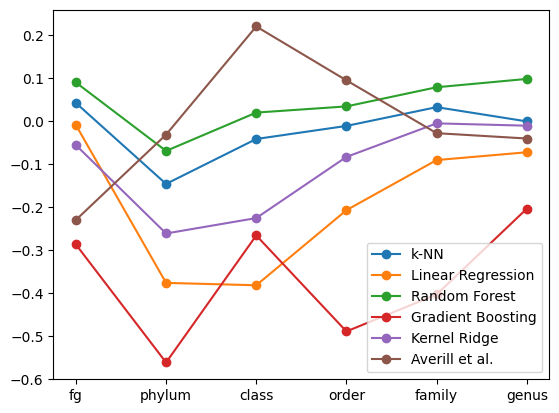

In [16]:
x = list(range(len(regression.TAXONOMIC_LEVELS)))

for model in models:
    if model == "Decision Tree":
        continue
    y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
    plt.plot(x, y, "-o", label=model)

plt.plot(x, published_results, "-o", label="Averill et al.")
plt.xticks(x, regression.TAXONOMIC_LEVELS)
plt.legend()
plt.show()

### Eliminate Columns

Evaluate performances by selecting the R square value of the three first
columns (i.e. taxa).

In [17]:
def test_with_limited_columns(n: int, ignore: str = None) -> None:
    # Evaluation
    results = regression.train_evaluate_models_multiple_taxa(
        models, X, Y, ignore=ignore, threshold=0.01, k_fold=5, keep_columns=n
    )

    published_results = []
    for level in regression.TAXONOMIC_LEVELS:
        published_prediction = pd.read_csv(f"{DATASET_PATH}{level}/predicted.csv")
        published_prediction = published_prediction.drop(published_prediction.columns[0], axis=1)
        if ignore:
            published_prediction = published_prediction.drop(columns=ignore)
            y_level = Y[level].copy()
            y_level = y_level.drop(columns=ignore)
        else:
            y_level = Y[level].copy()
        published_prediction = normalize_categories(published_prediction)
        r2 = regression.r2_score_by_column(y_level, published_prediction)[:n]
        print(f"{level}: {r2}")
        published_results.append(np.mean(r2))

    # Plot
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        if model == "Decision Tree":
            continue
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, published_results, "-o", label="Averill et al.")
    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    title = f"n = {n}" if ignore is None else f"n = {n}, ignore = {ignore}"
    plt.title(title)
    plt.axhline(y=0.0, linestyle='--')
    plt.show()

2024-05-24T07:46:38.006991 > INFO Evaluating 6 models with 5 splits.
2024-05-24T07:46:38.008178 > INFO Level: fg
2024-05-24T07:46:38.008178 > INFO K-fold split: 0
2024-05-24T07:46:38.013878 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:46:38.027498 >     Evaluated the model `k-NN`.
2024-05-24T07:46:38.038468 >     Evaluated the model `Linear Regression`.
2024-05-24T07:46:38.081310 >     Evaluated the model `Decision Tree`.
2024-05-24T07:46:38.191135 >     Evaluated the model `Random Forest`.
2024-05-24T07:46:38.520938 >     Evaluated the model `Gradient Boosting`.
2024-05-24T07:46:38.528133 >     Evaluated the model `Kernel Ridge`.
2024-05-24T07:46:38.528133 > INFO K-fold split: 1
2024-05-24T07:46:38.536198 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:46:38.543527 >     Evaluated the model `k-NN`.
2024-05-24T07:46:38.550461 >     Evaluated the model `Linear Regression`.
2024-05-24T07:46:38.562343 >     Evaluated the model `Decision Tree`.
2024-05-24T07:46:38.

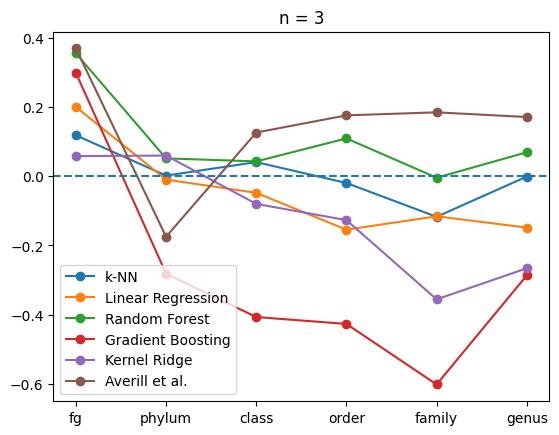

In [18]:
test_with_limited_columns(3)

2024-05-24T07:47:04.817835 > INFO Evaluating 6 models with 5 splits.
2024-05-24T07:47:04.823215 > INFO Level: fg
2024-05-24T07:47:04.824979 > INFO K-fold split: 0
2024-05-24T07:47:04.827255 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:47:04.840551 >     Evaluated the model `k-NN`.
2024-05-24T07:47:04.850846 >     Evaluated the model `Linear Regression`.
2024-05-24T07:47:04.860044 >     Evaluated the model `Decision Tree`.
2024-05-24T07:47:05.003809 >     Evaluated the model `Random Forest`.
2024-05-24T07:47:05.313959 >     Evaluated the model `Gradient Boosting`.
2024-05-24T07:47:05.353289 >     Evaluated the model `Kernel Ridge`.
2024-05-24T07:47:05.353289 > INFO K-fold split: 1
2024-05-24T07:47:05.353289 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:47:05.366794 >     Evaluated the model `k-NN`.
2024-05-24T07:47:05.378727 >     Evaluated the model `Linear Regression`.
2024-05-24T07:47:05.385656 >     Evaluated the model `Decision Tree`.
2024-05-24T07:47:05.

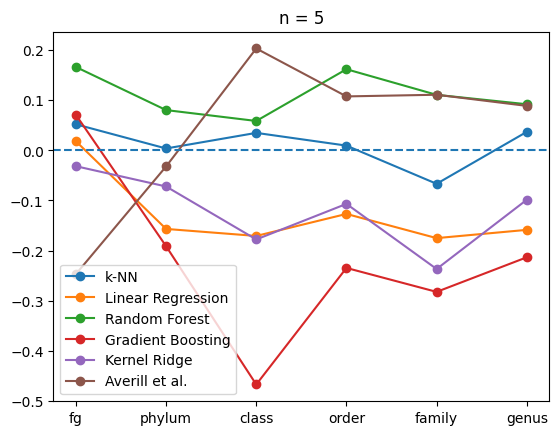

In [19]:
test_with_limited_columns(5)

2024-05-24T07:47:32.713112 > INFO Evaluating 6 models with 5 splits.
2024-05-24T07:47:32.715025 > INFO Level: fg
2024-05-24T07:47:32.718219 > INFO K-fold split: 0
2024-05-24T07:47:32.724133 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:47:32.743434 >     Evaluated the model `k-NN`.
2024-05-24T07:47:32.762948 >     Evaluated the model `Linear Regression`.
2024-05-24T07:47:32.777645 >     Evaluated the model `Decision Tree`.
2024-05-24T07:47:32.930087 >     Evaluated the model `Random Forest`.
2024-05-24T07:47:33.276684 >     Evaluated the model `Gradient Boosting`.
2024-05-24T07:47:33.288822 >     Evaluated the model `Kernel Ridge`.
2024-05-24T07:47:33.291650 > INFO K-fold split: 1
2024-05-24T07:47:33.295959 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:47:33.309756 >     Evaluated the model `k-NN`.
2024-05-24T07:47:33.317928 >     Evaluated the model `Linear Regression`.
2024-05-24T07:47:33.330641 >     Evaluated the model `Decision Tree`.
2024-05-24T07:47:33.

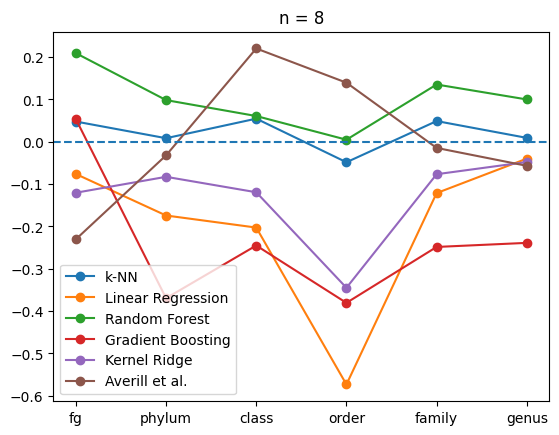

In [20]:
test_with_limited_columns(8)

In [21]:
test_with_limited_columns(3, "other")

2024-05-24T07:48:00.648298 > INFO Evaluating 6 models with 5 splits.
2024-05-24T07:48:00.649766 > INFO Level: fg
2024-05-24T07:48:00.651199 > INFO K-fold split: 0
2024-05-24T07:48:00.655985 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:48:00.665822 >     Evaluated the model `k-NN`.
2024-05-24T07:48:00.681030 >     Evaluated the model `Linear Regression`.
2024-05-24T07:48:00.693007 >     Evaluated the model `Decision Tree`.
2024-05-24T07:48:00.855069 >     Evaluated the model `Random Forest`.
2024-05-24T07:48:01.194823 >     Evaluated the model `Gradient Boosting`.
2024-05-24T07:48:01.209600 >     Evaluated the model `Kernel Ridge`.
2024-05-24T07:48:01.211062 > INFO K-fold split: 1
2024-05-24T07:48:01.214565 > INFO Beginning the evaluation of 6 models.
2024-05-24T07:48:01.228403 >     Evaluated the model `k-NN`.
2024-05-24T07:48:01.237835 >     Evaluated the model `Linear Regression`.
2024-05-24T07:48:01.251222 >     Evaluated the model `Decision Tree`.
2024-05-24T07:48:01.

2024-05-23T22:17:43.506799 > INFO Evaluating 6 models with 5 splits.
2024-05-23T22:17:43.506799 > INFO Level: fg
2024-05-23T22:17:43.510476 > INFO K-fold split: 0
2024-05-23T22:17:43.537724 > INFO Beginning the evaluation of 6 models.
2024-05-23T22:17:43.564890 >     Evaluated the model `k-NN`.
2024-05-23T22:17:43.580536 >     Evaluated the model `Linear Regression`.
2024-05-23T22:17:43.595760 >     Evaluated the model `Decision Tree`.
2024-05-23T22:17:43.707360 >     Evaluated the model `Random Forest`.
2024-05-23T22:17:44.016762 >     Evaluated the model `Gradient Boosting`.
2024-05-23T22:17:44.048477 >     Evaluated the model `Kernel Ridge`.
2024-05-23T22:17:44.048477 > INFO K-fold split: 1
2024-05-23T22:17:44.054282 > INFO Beginning the evaluation of 6 models.
2024-05-23T22:17:44.065681 >     Evaluated the model `k-NN`.
2024-05-23T22:17:44.075092 >     Evaluated the model `Linear Regression`.
2024-05-23T22:17:44.085923 >     Evaluated the model `Decision Tree`.
2024-05-23T22:17:44.

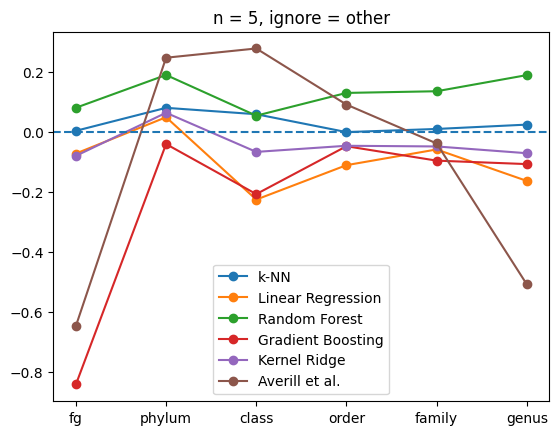

In [ ]:
test_with_limited_columns(5, "other")

2024-05-23T22:18:10.547189 > INFO Evaluating 6 models with 5 splits.
2024-05-23T22:18:10.551288 > INFO Level: fg
2024-05-23T22:18:10.552335 > INFO K-fold split: 0
2024-05-23T22:18:10.555265 > INFO Beginning the evaluation of 6 models.
2024-05-23T22:18:10.567343 >     Evaluated the model `k-NN`.
2024-05-23T22:18:10.579177 >     Evaluated the model `Linear Regression`.
2024-05-23T22:18:10.591026 >     Evaluated the model `Decision Tree`.
2024-05-23T22:18:10.755901 >     Evaluated the model `Random Forest`.
2024-05-23T22:18:11.067463 >     Evaluated the model `Gradient Boosting`.
2024-05-23T22:18:11.084884 >     Evaluated the model `Kernel Ridge`.
2024-05-23T22:18:11.084884 > INFO K-fold split: 1
2024-05-23T22:18:11.087942 > INFO Beginning the evaluation of 6 models.
2024-05-23T22:18:11.098700 >     Evaluated the model `k-NN`.
2024-05-23T22:18:11.112627 >     Evaluated the model `Linear Regression`.
2024-05-23T22:18:11.124137 >     Evaluated the model `Decision Tree`.
2024-05-23T22:18:11.

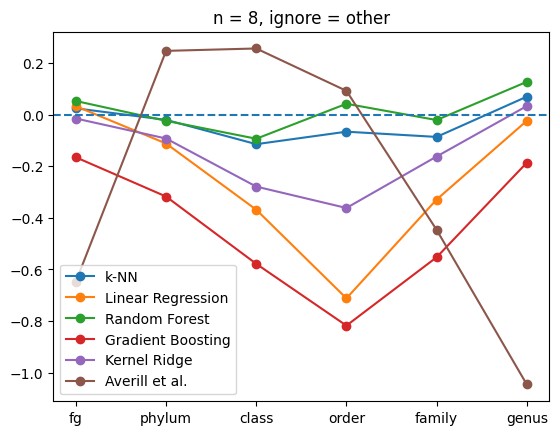

In [ ]:
test_with_limited_columns(8, "other")

## Transfer Learning with Fungi

Train the models on all available data points.

In [ ]:
models = {
    "k-NN": lambda: KNeighborsRegressor(20),
    "Linear Regression": lambda: LinearRegression(),
    "Decision Tree": lambda: DecisionTreeRegressor(),
    "Random Forest": lambda: RandomForestRegressor(),
    "Gradient Boosting": lambda: MultiOutputRegressor(GradientBoostingRegressor()),
    "Kernel Ridge": lambda: KernelRidge()
}
trained_models = {}
for level in regression.TAXONOMIC_LEVELS:
    trained_models[level] = {}
    for model in models:
        trained_models[level][model] = models[model]()
        trained_models[level][model].fit(X[level], Y[level])

In [ ]:
TRANSFER_DATASET_PATH = "data/averill_tranfer"
SAMPLING_LEVELS = ["core", "plot", "site"]

X2 = {}
Y2 = {}
averill_results = {}

for level in regression.TAXONOMIC_LEVELS:
    X2[level] = {}
    Y2[level] = {}
    averill_results[level] = {}
    for sampling in SAMPLING_LEVELS:
        x = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Variables/{level}_{sampling}_13Var.csv", delimiter=";")
        x = x.drop(x.columns[0], axis=1)
        x = normalize(x)
        y = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Observed/{level}_{sampling}_observed.csv")
        y = y.drop(y.columns[0], axis=1)
        y = normalize_categories(y)
        z = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Predicted/{level}_{sampling}_predicted.csv")
        z = z.drop(z.columns[0], axis=1)
        z = normalize_categories(z)
        X2[level][sampling] = x
        Y2[level][sampling] = y
        averill_results[level][sampling] = z

In [ ]:
X2["fg"]["core"].head()

,pC,cn,pH,NPP,map,mat,forest,conifer,relEM,P,K,Ca,Mg
0,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
1,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
2,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
3,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
4,0.449557,0.461103,0.107240,0.659976,0.800551,0.104998,1.0,1.0,0.634757,0.254657,0.264546,0.807743,0.861824


In [ ]:
Y2["fg"]["core"].head()

,other,Saprotroph,Ectomycorrhizal,Wood_Saprotroph,Animal_Pathogen,Plant_Pathogen
0,0.278330,0.169980,0.547714,0.001988,0.000994,0.000994
1,0.088469,0.344930,0.545726,0.012922,0.000994,0.006958
2,0.000994,0.007952,0.988072,0.000994,0.000994,0.000994
3,0.772366,0.075547,0.143141,0.006958,0.000994,0.000994
4,0.380716,0.147117,0.441352,0.028827,0.000994,0.000994


In [ ]:
averill_results["fg"]["core"].head()

,mean.other,mean.Saprotroph,mean.Ectomycorrhizal,mean.Wood_Saprotroph,mean.Animal_Pathogen,mean.Plant_Pathogen
0,0.169523,0.349924,0.318562,0.095838,0.030913,0.035241
1,0.169948,0.350793,0.317564,0.095564,0.030968,0.035163
2,0.171233,0.351855,0.315821,0.094760,0.031213,0.035119
3,0.171406,0.349828,0.316899,0.095593,0.031033,0.035241
4,0.197384,0.427429,0.180244,0.115199,0.034781,0.044962


In [ ]:
def test_averill_transfer(
        n: int = None, ignore: str = None, published_ignored: str = None
    ):

    results = {}

    for level in regression.TAXONOMIC_LEVELS:
        results[level] = {}
        for sampling in SAMPLING_LEVELS:
            if ignore:
                y_level = Y2[level][sampling].copy()
                y_level = y_level.drop(columns=ignore)
                published_result = averill_results[level][sampling].copy()
                published_result = published_result.drop(columns=published_ignored)
            else:
                published_result = averill_results[level][sampling].copy()
                y_level = Y2[level][sampling].copy()
            r2 = regression.r2_score_by_column(y_level, published_result)
            if n:
                results[level][sampling] = np.mean(r2[:n])
            else:
                results[level][sampling] = np.mean(r2)

    x = list(range(len(SAMPLING_LEVELS)))

    for level in results:
        y = [results[level][sampling] for sampling in results[level]]
        if sum(y) < -20:
            continue
        plt.plot(x, y, "-o", label=level)

    plt.xticks(x, SAMPLING_LEVELS)
    plt.legend()
    plt.show()

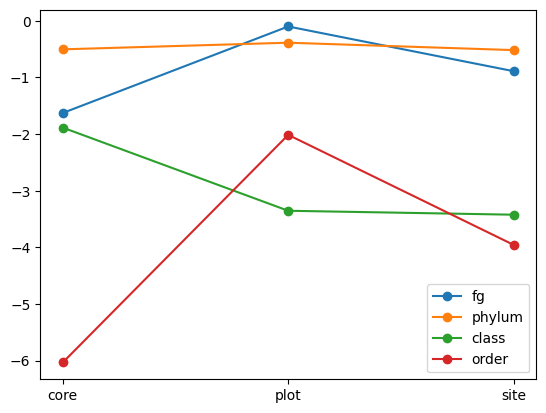

In [ ]:
test_averill_transfer()

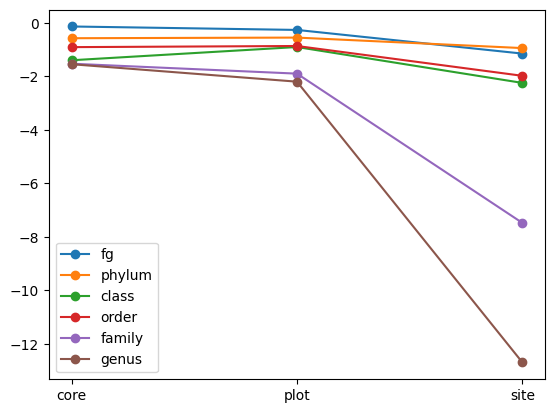

In [ ]:
test_averill_transfer(3)

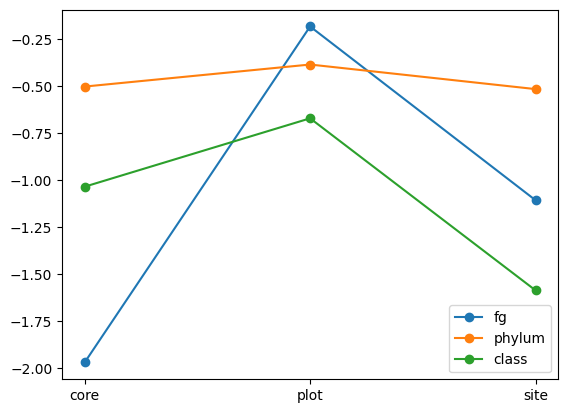

In [ ]:
test_averill_transfer(5)

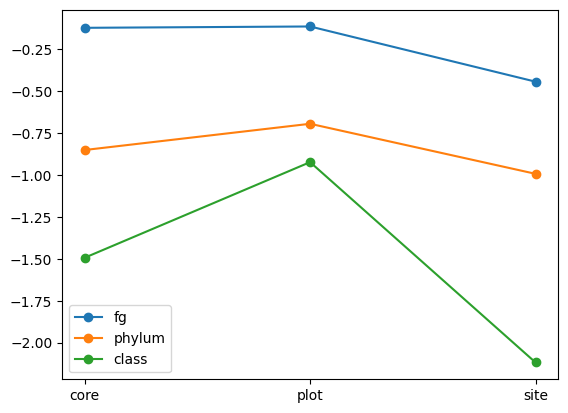

In [ ]:
test_averill_transfer(3, "other", "mean.other")

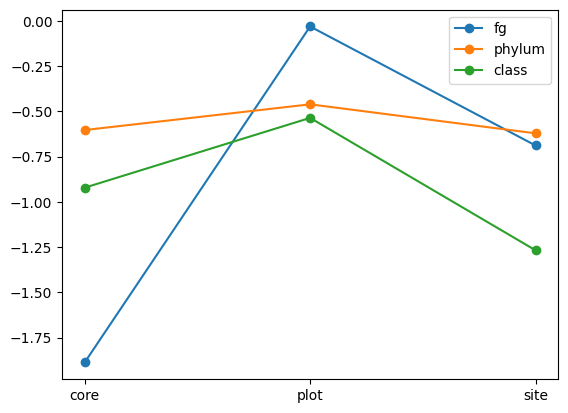

In [ ]:
test_averill_transfer(5, "other", "mean.other")

In [ ]:
X["fg"].head()

,pC,cn,pH,NPP,map,mat,forest,conifer,relEM,P,K,Ca,Mg
0,0.117690,0.137679,0.319820,0.456897,0.332847,0.229954,1.0,1.0,0.95,0.689368,0.370576,0.653786,0.214249
1,0.410766,0.285934,0.200450,0.456897,0.350451,0.224292,1.0,1.0,1.00,0.803620,0.403604,0.638502,0.171916
2,0.614954,0.666470,0.074324,0.482759,0.340660,0.235251,1.0,1.0,1.00,0.879013,0.761538,0.688865,0.302511
3,0.741352,0.342608,0.333333,0.456897,0.338446,0.234155,1.0,1.0,0.95,0.855072,0.703136,0.906135,0.548063
4,0.122018,0.248959,0.743243,0.456897,0.349377,0.233607,1.0,0.0,0.99,0.657549,0.524231,0.826396,0.454103


In [ ]:
X2["fg"]["core"].head()

,pC,cn,pH,NPP,map,mat,forest,conifer,relEM,P,K,Ca,Mg
0,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
1,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
2,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
3,0.409551,0.493222,0.183508,0.659976,0.800551,0.104998,1.0,1.0,0.684333,0.523519,0.323785,0.677458,0.762925
4,0.449557,0.461103,0.107240,0.659976,0.800551,0.104998,1.0,1.0,0.634757,0.254657,0.264546,0.807743,0.861824


fg
    core
fg core [-0.47266634922778494, -1.1972983406784818, -0.154995630867528, -0.634128318844501, -0.17316556750396273, 0.022784368094394325]
    plot
fg plot [-0.8417627470359241, -2.8742046253321853, -0.2544911003806569, -0.9913063825580655, -2.928468497181131, -0.42041807531871567]
    site
fg site [-1.9197604308476568, -7.050888628846691, -1.052354122324786, -1.662653339914844, -10.799229230726755, -1.2228441134519192]
phylum
    core
phylum core [-0.04588351893873455, -2.4809211411378542, -0.1789540234221294, -2.0420314507751502, -0.4073647943286325]
    plot
phylum plot [-0.4552262183286344, -3.288719757011889, -0.19770599656646226, -3.5818230066506933, -0.5978737325060066]
    site
phylum site [-1.3458424918831247, -7.900714722814454, -0.4332151536710447, -9.285142966793098, -0.8319559275276773]
class
    core
class core [-0.4234518207311786, -2.5245751554536513, -2.786896224482476, -2.5016382094734713, -0.32774618803043754, -0.08932123338252573, -9.678670002126065, -0.638

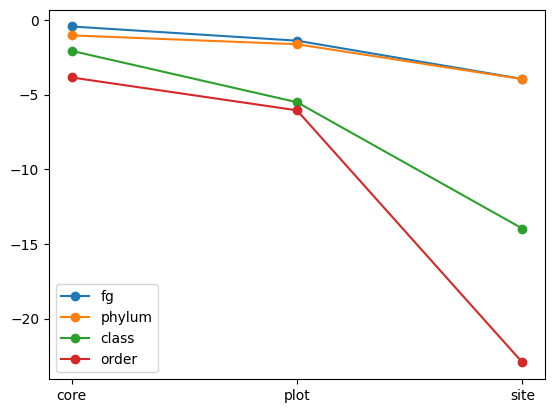

In [ ]:
x = list(range(len(SAMPLING_LEVELS)))

model_names = [
    "k-NN",
    "Linear Regression",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting",
    "Kernel Ridge"
]
model_name = model_names[5]

for level in regression.TAXONOMIC_LEVELS:
    print(level)
    if level == "genus":
        continue
    r = []
    for sampling in SAMPLING_LEVELS:
        print(f"    {sampling}")
        y = Y2[level][sampling]
        y_pred = trained_models[level][model_name].predict(X2[level][sampling])
        r2 = regression.r2_score_by_column(y, y_pred)
        print(level, sampling, r2)
        r.append(np.mean(r2))
    if sum(r) < -500:
        continue
    plt.plot(x, r, "-o", label=level)

plt.xticks(x, SAMPLING_LEVELS)
plt.legend()
plt.title(model_name)
plt.show()